In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline
import plotly
import plotly.figure_factory as ff
from plotly.offline import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier



pd.set_option('display.max_columns', 300)

In [3]:
demo_features = ['X2SEX', 'X2RACE', 'X2DUALLANG', 'X2POVERTY185', 'X2SESQ5_U', 'X2CONTROL', 'X2LOCALE', 'X2REGION', 'X3TCREDSCI']


mvp_features = ['X2STU30OCC_STEM1', 'X2STUEDEXPCT', 'X2S2SSPR12', 'S2SPERSON1', 'S2SPERSON2', 
               'S2SLEARN', 'S2SBORN', 'S2SUSELIFE', 'S2SUSECLG', 'S2SUSEJOB', 
               'S2SSPR12', 'S2LIFES12', 'S2BIO1S12', 'S2BIO2S12', 'S2APBIOS12', 
               'S2IBIOS12', 'S2ANATOMYS12', 'S2OTHBIOS12', 'S2CHEM1S12', 'S2CHEM2S12', 'S2APCHEM12', 
               'S2IBCHEM12', 'S2EARTHS12', 'S2APENVS12', 'S2OTHENVS12', 'S2PHYSIC1S12', 
               'S2PHYSIC2S12', 'S2APPHYSIC12', 'S2IBPHYSIC12', 'S2PHYSS12', 'S2TECHS12', 'S2OTHPHYS12', 
               'S2INTGS1S12', 'S2INTGS2S12', 'S2GENS12', 'S2COMPAPP12', 'S2COMPPROG12', 
               'S2APCOMPSCI12', 'S2IBTECH12', 'S2OTHCOMP12', 'S2ENGINEER12', 'S2OTHS12', 'S2OTHS12SP', 
               'S2HISCIENCE12', 'S2APSCIENCE', 'S2IBSCIENCE', 'S2STOOKBEFORE', 'S2SENJOYS', 'S2SCHALLENGE', 'S2SHSREQ', 'S2SCLGADM', 
               'S2SCLGSUCC', 'S2SCAREER', 'S2SCNSLREC', 'S2STCHRREC', 'S2SPARREC', 'S2SFAMREC', 
               'S2SEMPREC', 'S2SFRIEND', 'S2SDOWELL', 'S2SASSIGNED', 'S2STCHTREAT', 'S2STCHINTRST', 
               'S2STCHEASY', 'S2STCHTHINK', 'S2STCHGIVEUP', 'S2SENJOYING', 'S2SWASTE', 'S2SBORING', 
               'S2SUSELIFE', 'S2SUSECLG', 'S2SUSEJOB', 'S2STESTS', 'S2STEXTBOOK', 'S2SSKILLS', 
               'S2SASSEXCL', 'S2APSCIENCE', 'S2HSPLAN', 'S2SUBMITPLAN', 'S2SCLUB', 
            'S2SCOMPETE', 'S2SSUMMERPRG', 'S2SGROUP', 'S2STUTORED', 'X4RFDGMJ123', 'X4RFDGMJSTEM']

family_features = ['X2PAR1EDU', 'X2PAR1OCC_STEM1', 
            'X2PAR1RACE', 'X2PAR2EDU', 'X2PAR2OCC_STEM1', 'X2PAR2RACE', 'X2PARPATTERN', 
            'X2MOMEDU', 'X2MOMOCC_STEM1', 'X2MOMRACE', 'X2DADEDU', 'X2DADOCC_STEM1', 
            'X2DADRACE']

cols_list = demo_features + mvp_features



In [10]:
df = pd.read_csv('../data-files/HSLS/hsls_17_student_pets_sr_v1_0.csv', usecols = cols_list)
df.rename(columns = {'X4RFDGMJSTEM': 'target'}, inplace = True)

In [11]:
df['female'] = np.where(df['X2SEX'] == 2, 1, 0)


In [12]:
#drop rows with non-response to S2SLEARN (and many other features) (likely dropped from study)
df = df[df['S2SLEARN'] != -8]

#create dummy variables for races
df['ai_an'] = np.where(df['X2RACE'] == 1, 1, 0)
df['asian'] = np.where(df['X2RACE'] == 2, 1, 0)
df['black'] = np.where(df['X2RACE'] == 3, 1, 0)
df['hispanic'] = np.where((df['X2RACE'] == 4) | (df['X2RACE'] == 5), 1, 0)
df['multiple_race'] = np.where(df['X2RACE'] == 6, 1, 0)
df['nh_pi'] = np.where(df['X2RACE'] == 7, 1, 0)
df['white'] = np.where(df['X2RACE'] == 8, 1, 0)

#combine hispanic into one column
df['X2RACE'].replace({4:5}, inplace = True)


In [13]:
#'X2DUALLANG', 'X2POVERTY185', 'X2SESQ5_U', 'X2CONTROL', 'X2LOCALE', 'X2REGION'

#create dummy for public/private school
df['private'] = [1 if x == 2 else 0 for x in df['X2CONTROL']]
df['public'] = [1 if x == 1 else 0 for x in df['X2CONTROL']]

In [14]:
#compile all subchoices of STEM domains into yes/no
df.X2STU30OCC_STEM1.replace({-9:0, 9:0, 4:1, 5:1, 6:1}, inplace = True)


In [15]:
classes = ['S2SSPR12', 'S2LIFES12', 'S2BIO1S12', 'S2BIO2S12', 'S2APBIOS12', 
               'S2IBIOS12', 'S2ANATOMYS12', 'S2OTHBIOS12', 'S2CHEM1S12', 'S2CHEM2S12', 'S2APCHEM12', 
               'S2IBCHEM12', 'S2EARTHS12', 'S2APENVS12', 'S2OTHENVS12', 'S2PHYSIC1S12', 
               'S2PHYSIC2S12', 'S2APPHYSIC12', 'S2IBPHYSIC12', 'S2PHYSS12', 'S2TECHS12', 'S2OTHPHYS12', 
               'S2INTGS1S12', 'S2INTGS2S12', 'S2GENS12', 'S2COMPAPP12', 'S2COMPPROG12', 
               'S2APCOMPSCI12', 'S2IBTECH12', 'S2OTHCOMP12', 'S2ENGINEER12', 'S2OTHS12', 'S2APSCIENCE', 'S2IBSCIENCE']

#impute 'no' for items that are missing or were skipped due to not taking a science class
for col in classes:
    df[col].replace({-9:0, -7:0}, inplace= True)


In [16]:
df.S2SSPR12.value_counts()

1    16192
0     4402
Name: S2SSPR12, dtype: int64

In [17]:
#impute unknown with 'no' for if participating in science activity

clubs_cols = ['S2SCLUB', 'S2SCOMPETE', 'S2SSUMMERPRG', 'S2SGROUP', 'S2STUTORED']

for col in clubs_cols:
    df[col].replace({-9:0}, inplace = True)

In [18]:
df.S2HSPLAN = np.where(df['S2HSPLAN'] == 1, 1, 0)
df.S2SUBMITPLAN = np.where(df['S2SUBMITPLAN'] == 1, 1, 0)

In [19]:
#create class for underrepresented group in STEM (women, black, american indian, hispanic, pacific islander)

df['underrep'] = np.where((df['X2SEX'] == 2) |
                          (df['ai_an'] == 1) |
                          (df['black'] == 1) |
                          (df['hispanic'] == 1) |
                          (df['multiple_race'] == 1) |
                          (df['nh_pi'] == 1), 1, 0)
                         

In [20]:
df['EXPECT'] = df['X2STUEDEXPCT'].replace({1:1, 2:2, 3:2, 4:3, 5:2, 6:4, 7:4, 8:5, 9:5, 10:6, 11:6, 12:7, 13:8})

In [21]:
#group HS science classes into broader subjects

df['bio'] = np.where((df['S2LIFES12'] == 1) |
                      (df['S2BIO1S12'] == 1) |
                      (df['S2BIO2S12'] == 1) |
                      (df['S2APBIOS12'] == 1) |
                      (df['S2IBIOS12'] == 1) |
                     (df['S2ANATOMYS12'] == 1) |
                      (df['S2OTHBIOS12'] == 1), 1, 0)
               

df['chem'] = np.where((df['S2CHEM1S12'] == 1) |
                      (df['S2CHEM2S12'] == 1) |
                      (df['S2APCHEM12'] == 1) |
                      (df['S2IBCHEM12'] == 1), 1, 0)
              

df['enviro'] = np.where((df['S2EARTHS12'] == 1) |
                        (df['S2EARTHS12'] == 1) |
                        (df['S2APENVS12'] == 1) |
                        (df['S2OTHENVS12'] == 1), 1, 0)
                        
df['physics'] = np.where((df['S2PHYSIC1S12'] == 1) |
                         (df['S2PHYSIC2S12'] == 1) |
                         (df['S2APPHYSIC12'] == 1) |
                         (df['S2IBPHYSIC12'] == 1) |
                         (df['S2PHYSS12'] == 1), 1, 0)
                         
df['engineering'] = np.where((df['S2ENGINEER12'] == 1), 1, 0)


df['compsci'] = np.where((df['S2COMPAPP12'] == 1) |
                         (df['S2COMPPROG12'] == 1) |
                         (df['S2APCOMPSCI12'] == 1) |
                         (df['S2IBTECH12'] == 1) |
                         (df['S2OTHCOMP12'] == 1), 1, 0)

df['misc_class'] = np.where((df['S2OTHPHYS12'] == 1) |
                            (df['S2INTGS1S12'] == 1) |
                            (df['S2GENS12'] == 1), 1, 0)


In [22]:
#create column for students who took science earlier in the year (but don't now)
df['took_science_2012'] = np.where((df['S2STOOKBEFORE'] == 1) |
                                   (df['bio'] == 1) |
                                   (df['chem'] == 1) |
                                   (df['enviro'] == 1) |
                                   (df['physics'] == 1) |
                                   (df['engineering'] == 1) |
                                   (df['compsci'] == 1) |
                                   (df['misc_class'] == 1), 1, 0)


In [23]:
df.took_science_2012.value_counts()

1    18051
0     2543
Name: took_science_2012, dtype: int64

In [24]:
#impute 'no' for items that are missing or were skipped due to not taking a science class

why_science = ['S2SENJOYS', 'S2SCHALLENGE', 'S2SHSREQ', 'S2SCLGADM', 
               'S2SCLGSUCC', 'S2SCAREER', 'S2SCNSLREC', 'S2STCHRREC', 'S2SPARREC', 'S2SFAMREC', 
               'S2SEMPREC', 'S2SFRIEND', 'S2SDOWELL', 'S2SASSIGNED']

for col in why_science:
    df[col].replace({-9:0, -7:0}, inplace= True)

In [25]:
#create dataframe with target variable
modeling_df = df[(df.target == 0) | (df.target == 1)]



In [26]:
likert_cols = ['S2SPERSON1', 'S2SPERSON2', 
               'S2SLEARN', 'S2SBORN', 'S2SUSELIFE', 'S2SUSECLG', 'S2SUSEJOB', 
                'S2STCHTREAT', 'S2STCHINTRST', 
               'S2STCHEASY', 'S2STCHTHINK', 'S2STCHGIVEUP', 'S2SENJOYING', 'S2SWASTE', 'S2SBORING', 
               'S2STESTS', 'S2STEXTBOOK', 'S2SSKILLS', 
               'S2SASSEXCL']

#change likert questions to agree/disagree
for col in likert_cols:
   modeling_df[col].replace({2:1, 3:0, 4:0, -9:0, }, inplace = True)

In [27]:
gender = pd.DataFrame(data = modeling_df.X2SEX.value_counts(normalize = True), columns = ['X2SEX'])
gender.reset_index(inplace=True)
gender.rename(columns = {'X2SEX':'value', 'index' : 'X2SEX'}, inplace = True)
gender

,X2SEX,value
0,2,0.547567
1,1,0.452433


In [28]:
modeling_df.groupby(by = ['target'])['X2SEX'].value_counts(normalize = True)

#create dataframe of groupby objects (distribution of majors vs overall)
target_gender = pd.DataFrame(modeling_df.groupby(by = ['target'])['X2SEX'].value_counts(normalize = True))
gender = pd.DataFrame(data = modeling_df.X2SEX.value_counts(normalize = True), columns = ['X2SEX'])

#change name of column to value to not confused with target variable
target_gender.rename(columns = {'X2SEX':'value'}, inplace = True)

#change multindex to individual columns
target_gender.reset_index(inplace=True, level = ('target', 'X2SEX'))

#isolate only students choosing a stem major
target_gender = target_gender[target_gender['target'] != 0]

#reset overall distribution df index and change column titles to align with other df
gender.reset_index(inplace=True)
gender.rename(columns = {'X2SEX':'value', 'index' : 'X2SEX'}, inplace = True)

#append overall distribution to target distribution
target_gender = target_gender.append(gender, sort = True)

#change 1/2 to male/female labels
target_gender['X2SEX'] = target_gender['X2SEX'].map({1: 'Male', 2: 'Female'})

NameError: name 'male_target' is not defined

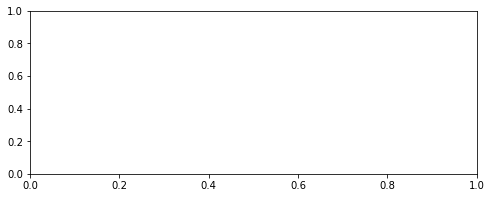

In [29]:
#create x-values for barchart
males = target_gender[target_gender['X2SEX'] == 'Male']['value'].values
females = target_gender[target_gender['X2SEX'] == 'Female']['value'].values

label = ['STEM Majors', 'All Students']
fig = plt.figure(figsize = (8, 3))
ax = fig.add_subplot(111)
ax.barh(label, male_target, align='center', color='skyblue',label='Males')
ax.barh(label, female_target, align='center', left=male_target, color='purple',label='Females')
ax.set_yticks(label)
ax.set_xlabel('Percentage')
ax.set_title('Gender Distribution of STEM Majors vs All Majors')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

In [ ]:
#labels = ['Expects to Have a STEM Career at 30 (2009)', 'Pursuing STEM Major (2016)']
#no_STEM = difference_in_expectations[0]
#yes_STEM = difference_in_expectations[1].values

#x = np.arange(len(labels))  # the label locations
#width = 0.1  # the width of the bars


stem_career = pd.DataFrame(data = modeling_df.X2STU30OCC_STEM1.value_counts(normalize = True).values, index = modeling_df.X2STU30OCC_STEM1.value_counts(normalize = True).index, columns = ["2009"])
stem_major = pd.DataFrame(data = modeling_df.target.value_counts(normalize = True).values, index = modeling_df.target.value_counts(normalize = True).index, columns= ['2016'])

difference_in_expectations = pd.concat([stem_career, stem_major], axis = 1).T
yes_STEM = difference_in_expectations[1].values

fig, ax = plt.subplots(figsize = (7, 5))
ax.bar(['Expects to Have a STEM Career at 30 (2009)', 'Pursuing STEM Major (2016)'], yes_STEM)
ax.set_ylabel('Percentage of Students')
ax.set_title('Percentages of Students Interested in STEM by Year');


In [ ]:
modeling_df.female.value_counts(normalize = True)

In [ ]:
modeling_df[modeling_df['X2STU30OCC_STEM1'] != modeling_df['target']]['female'].value_counts(normalize = True)

In [30]:
dropstem = pd.DataFrame(data = modeling_df[modeling_df['X2STU30OCC_STEM1'] != modeling_df['target']]['female'].value_counts(normalize = True).values, columns= ['percentage'])
dropstem


,percentage
0,0.6046
1,0.3954


In [31]:
underrep_dist = pd.DataFrame(data = modeling_df['female'].value_counts(normalize = True).values, columns = ['female'])
underrep_dist

droppedstem = pd.concat([dropstem, underrep_dist], axis = 1)




Text(0, 0.5, 'Number of Students')

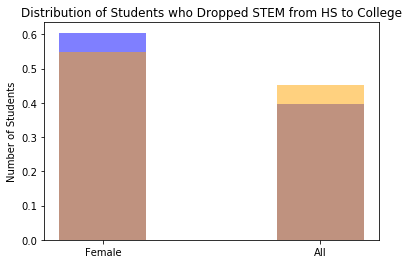

In [32]:
ind = np.arange(2)
labels = ['Female', 'All']

plt.bar(ind, droppedstem['percentage'], width = 0.4, alpha = 0.5, color = 'blue')
plt.bar(ind, droppedstem['female'], width = 0.4, alpha = 0.5, color = 'orange')
plt.xticks(ind, labels)
plt.title('Distribution of Students who Dropped STEM from HS to College')
plt.ylabel('Number of Students')

1 not finish high school
2 complete high school
3 trade school
4 complete associates
5 complete bachelors
6 complete masters
7 complete phd
8 do not know

In [33]:
df['EXPECT'] = df['X2STUEDEXPCT'].replace({1:1, 2:2, 3:2, 4:3, 5:2, 6:4, 7:4, 8:5, 9:5, 10:6, 11:6, 12:7, 13:8})

In [290]:
expectations = pd.DataFrame(data = df.groupby('X2SEX')['EXPECT'].value_counts(normalize = True)).unstack()
expectations = expect.unstack()
expectations.columns = ['No HS Diploma', 'HS Diploma', 'Certificate', 'Associate Degree', 'Bachelor Degree', 'Masters Degree', 'PhD', 'Unsure']
expectations.index = ['Male', 'Female']
expectations

,No HS Diploma,HS Diploma,Certificate,Associate Degree,Bachelor Degree,Masters Degree,PhD,Unsure
male,0.007319,0.123267,0.057203,0.102562,0.284284,0.194723,0.117681,0.112962
female,0.003820,0.070421,0.043585,0.098923,0.279236,0.245837,0.166797,0.091381


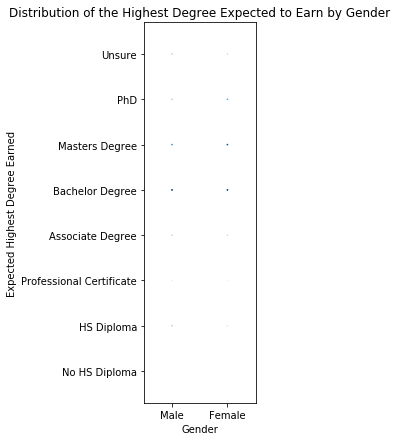

In [778]:
expectations = pd.DataFrame(data = df.groupby('X2SEX')['EXPECT'].value_counts(normalize = True)).unstack()
expectations.columns = ['No HS Diploma', 'HS Diploma', 'Professional Certificate', 'Associate Degree', 'Bachelor Degree', 'Masters Degree', 'PhD', 'Unsure']
expectations.index = ['Male', 'Female']
expectations

x,y = np.meshgrid(expectations.columns, expectations.index)
expectations *= 2

plt.figure(figsize = (2, 7))
plt.scatter(x=y.flatten(), y=x.flatten(), s=expectations.values.flatten(), c = expectations.values.flatten(),  cmap= 'Blues')
plt.title('Distribution of the Highest Degree Expected to Earn by Gender')
plt.xlabel('Gender')
plt.ylabel('Expected Highest Degree Earned')
plt.margins(0.5, 0.1)
plt.show()

In [288]:
race_expectations = pd.DataFrame(data = df.groupby('X2RACE')['EXPECT'].value_counts(normalize = True)).unstack()
race_expectations = race_expect.unstack()
race_expectations.columns = ['No HS Diploma', 'HS Diploma', 'Certificate', 'Associate Degree', 'Bachelor Degree', 'Masters Degree', 'PhD', 'Unsure']
race_expectations.index = ['American Indian/Alaska Native', 'Asian', 'Black/African American', 'Hispanic', 'Multiple Races', 'Native Hawaiian/Pacific Islander', 'White']

x,y = np.meshgrid(race_expectations.columns, race_expectations.index)
race_expectations *= 0.85

plt.figure(figsize = (8, 8))
plt.scatter(x=y.flatten(), y=x.flatten(), s=race_expectations.values.flatten(), c = race_expectations.values.flatten(),  cmap= 'Blues')
plt.xticks(rotation=75)

plt.margins(0.1, 0.1)
plt.show()

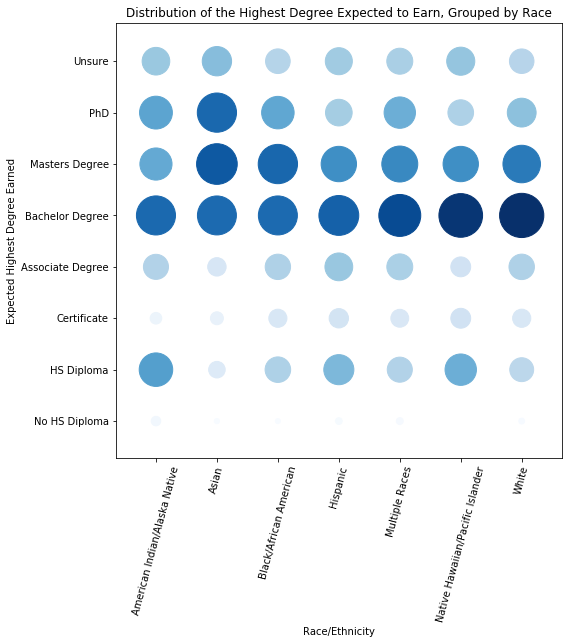

In [779]:
x,y = np.meshgrid(race_expectations.columns, race_expectations.index)
#race_expectations *= 0.85

plt.figure(figsize = (8, 8))
plt.scatter(x=y.flatten(), y=x.flatten(), s=race_expectations.values.flatten(), c = race_expectations.values.flatten(),  cmap= 'Blues')
plt.xticks(rotation=75)
plt.title('Distribution of the Highest Degree Expected to Earn, Grouped by Race')
plt.xlabel('Race/Ethnicity')
plt.ylabel('Expected Highest Degree Earned')
plt.margins(0.1, 0.1)
plt.show()

### Percentage of Race/Gender Majoring in STEM

In [559]:
#create dataframe of groupby object
target_demo = pd.DataFrame(modeling_df.groupby(by = ['X2RACE','X2SEX'])['target'].value_counts(normalize = True))
#change name of column to value to not confused with target variable
target_demo.rename(columns = {'target':'value'}, inplace = True)
#change multindex to individual columns
target_demo.reset_index(inplace=True, level = ('X2RACE', 'X2SEX', 'target'))
#change 1/2 to male/female labels
target_demo['X2SEX'] = target_demo['X2SEX'].map({1: 'Male', 2: 'Female'})
#isolate only students choosing a stem major
target_demo = target_demo[target_demo['target'] != 0]

''

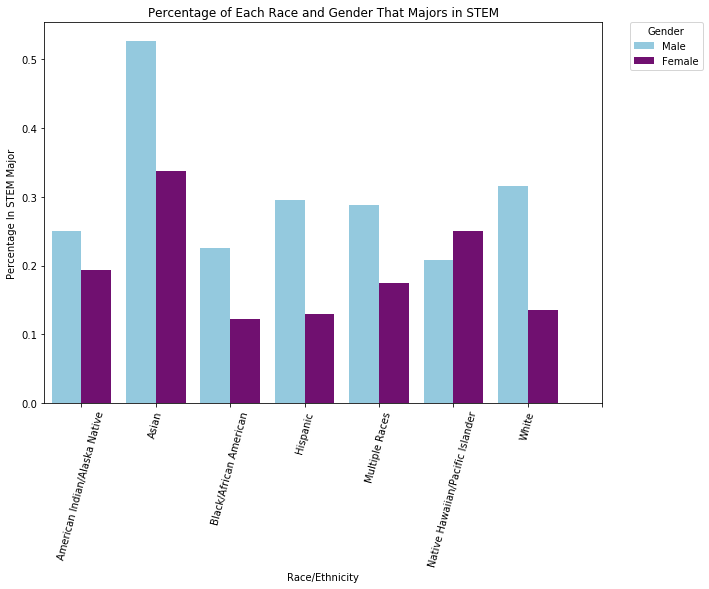

In [690]:
plt.figure(figsize = (10, 7))
sns.barplot(x = 'X2RACE', y = 'value', hue = 'X2SEX', data = target_demo, palette = {'Male':'skyblue', 'Female':'purple'})
plt.xlabel('Race/Ethnicity')
plt.ylabel('Percentage In STEM Major') 
plt.title('Percentage of Each Race and Gender That Majors in STEM')
plt.xticks(ticks = range(0,8), rotation = 75, labels = ['American Indian/Alaska Native', 'Asian', 'Black/African American', 'Hispanic', 'Multiple Races', 'Native Hawaiian/Pacific Islander', 'White'])
plt.legend(title = 'Gender', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

;

''

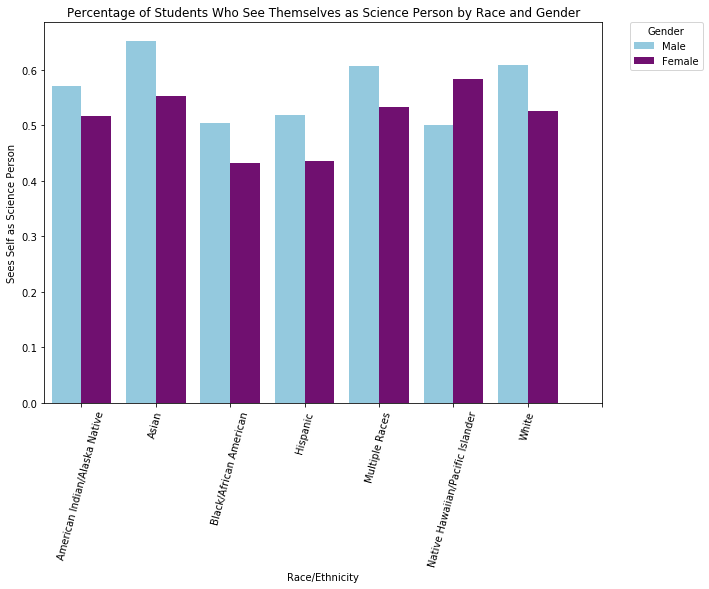

In [769]:
#create dataframe of groupby object
person_demo = pd.DataFrame(modeling_df.groupby(by = ['X2RACE','X2SEX'])['S2SPERSON1'].value_counts(normalize = True))
#change name of column to value to not confused with target variable
person_demo.rename(columns = {'S2SPERSON1':'value'}, inplace = True)
#change multindex to individual columns
person_demo.reset_index(inplace=True, level = ('X2RACE', 'X2SEX', 'S2SPERSON1'))
#change 1/2 to male/female labels
person_demo['X2SEX'] = person_demo['X2SEX'].map({1: 'Male', 2: 'Female'})
#isolate only students choosing a stem major
person_demo = person_demo[person_demo['S2SPERSON1'] != 0]


plt.figure(figsize = (10, 7))
sns.barplot(x = 'X2RACE', y = 'value', hue = 'X2SEX', data = person_demo, palette = {'Male':'skyblue', 'Female':'purple'})
plt.xlabel('Race/Ethnicity')
plt.ylabel('Sees Self as Science Person') 
plt.title('Percentage of Students Who See Themselves as Science Person by Race and Gender')
plt.xticks(ticks = range(0,8), rotation = 75, labels = ['American Indian/Alaska Native', 'Asian', 'Black/African American', 'Hispanic', 'Multiple Races', 'Native Hawaiian/Pacific Islander', 'White'])
plt.legend(title = 'Gender', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
;



''

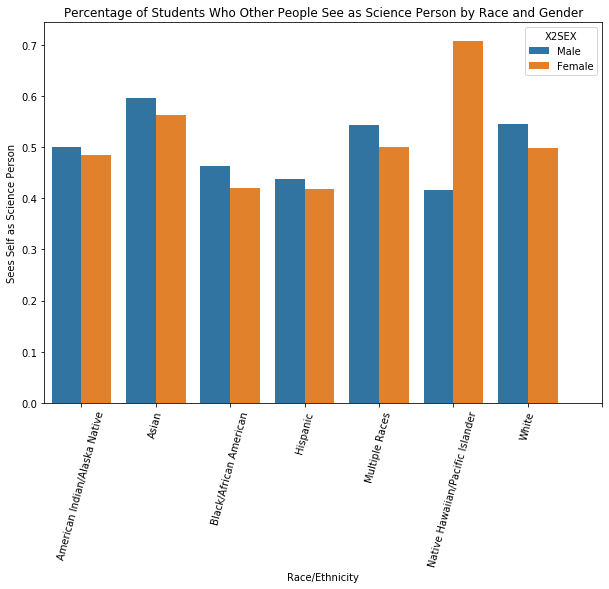

In [415]:
#create dataframe of groupby object
otherperson_demo = pd.DataFrame(modeling_df.groupby(by = ['X2RACE','X2SEX'])['S2SPERSON2'].value_counts(normalize = True))
#change name of column to value to not confused with target variable
otherperson_demo.rename(columns = {'S2SPERSON2':'value'}, inplace = True)
#change multindex to individual columns
otherperson_demo.reset_index(inplace=True, level = ('X2RACE', 'X2SEX', 'S2SPERSON2'))
#change 1/2 to male/female labels
otherperson_demo['X2SEX'] = otherperson_demo['X2SEX'].map({1: 'Male', 2: 'Female'})
#isolate only students who others see as science
otherperson_demo = otherperson_demo[otherperson_demo['S2SPERSON2'] != 0]


plt.figure(figsize = (10, 7))
sns.barplot(x = 'X2RACE', y = 'value', hue = 'X2SEX', data = otherperson_demo)
plt.xlabel('Race/Ethnicity')
plt.ylabel('Sees Self as Science Person') 
plt.title('Percentage of Students Who Other People See as Science Person by Race and Gender')
plt.xticks(ticks = range(0,8), rotation = 75, labels = ['American Indian/Alaska Native', 'Asian', 'Black/African American', 'Hispanic', 'Multiple Races', 'Native Hawaiian/Pacific Islander', 'White'])
;



In [418]:
#create dataframes for STEM majors vs non STEM majors for EDA
STEM_df = modeling_df[modeling_df['target'] == 1]
nonSTEM_df = modeling_df[modeling_df['target'] == 0]

'S2STCHTREAT', 'S2STCHINTRST', 
               'S2STCHEASY', 'S2STCHTHINK', 'S2STCHGIVEUP'

In [425]:
modeling_df.S2STCHEASY.value_counts(normalize = True)

 1    0.557226
 0    0.299526
-7    0.143248
Name: S2STCHEASY, dtype: float64

In [434]:
taking_science_df = modeling_df[modeling_df['S2STCHEASY'] != -7]

In [439]:
taking_science_df.groupby(by = ['target'])['S2STCHTHINK'].value_counts(normalize = True)

target  S2STCHTHINK
0       1              0.772644
        0              0.227356
1       1              0.814590
        0              0.185410
Name: S2STCHTHINK, dtype: float64

''

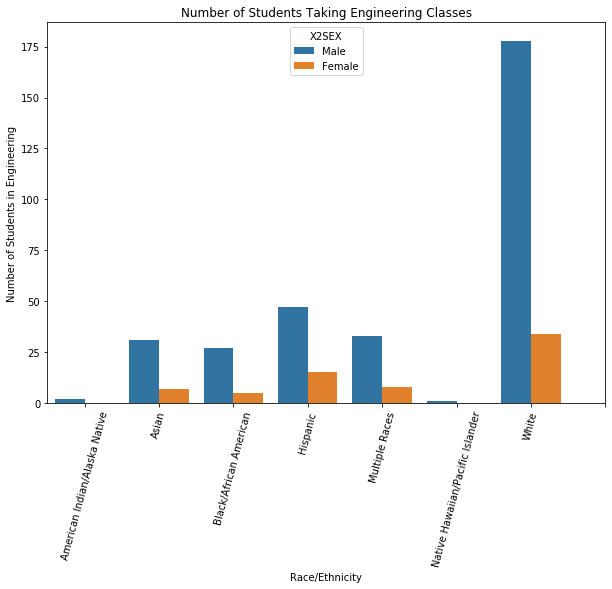

In [767]:
#create dataframe of groupby object
engineering_demo = pd.DataFrame(df[df['engineering'] == 1].groupby(by = ['X2RACE'])['X2SEX'].value_counts(normalize = False))
#change name of column to value to not confused with target variable
engineering_demo.rename(columns = {'X2SEX':'value'}, inplace = True)
#change multindex to individual columns
engineering_demo.reset_index(inplace=True, level = ('X2RACE', 'X2SEX'))
#change 1/2 to male/female labels
engineering_demo['X2SEX'] = engineering_demo['X2SEX'].map({1: 'Male', 2: 'Female'})



plt.figure(figsize = (10, 7))
sns.barplot(x = 'X2RACE', y = 'value', hue = 'X2SEX', data = engineering_demo)
plt.xlabel('Race/Ethnicity')
plt.ylabel('Number of Students in Engineering') 
plt.title('Number of Students Taking Engineering Classes')
plt.xticks(ticks = range(0,8), rotation = 75, labels = ['American Indian/Alaska Native', 'Asian', 'Black/African American', 'Hispanic', 'Multiple Races', 'Native Hawaiian/Pacific Islander', 'White'])
;



In [766]:
engineering_demo

,X2RACE,X2SEX,value
0,1,Male,2
1,2,Male,31
2,2,Female,7
3,3,Male,27
4,3,Female,5
5,5,Male,47
6,5,Female,15
7,6,Male,33
8,6,Female,8
9,7,Male,1


''

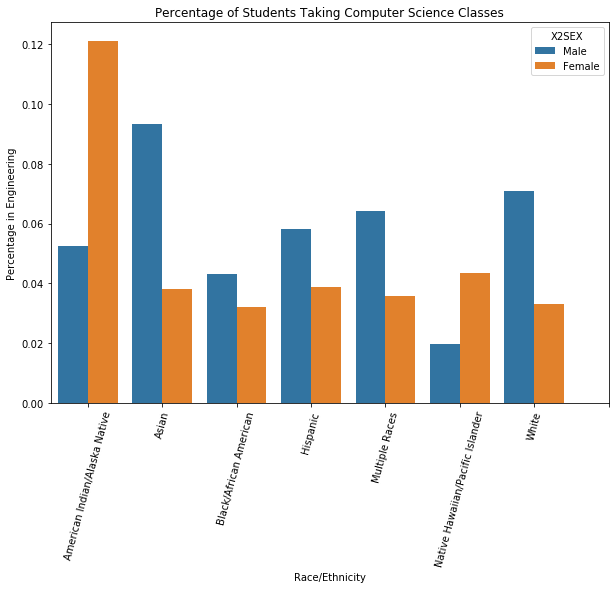

In [506]:
#create dataframe of groupby object
compsci_demo = pd.DataFrame(df.groupby(by = ['X2RACE','X2SEX'])['compsci'].value_counts(normalize = True))
#change name of column to value to not confused with target variable
compsci_demo.rename(columns = {'compsci':'value'}, inplace = True)
#change multindex to individual columns
compsci_demo.reset_index(inplace=True, level = ('X2RACE', 'X2SEX', 'compsci'))
#change 1/2 to male/female labels
compsci_demo['X2SEX'] = compsci_demo['X2SEX'].map({1: 'Male', 2: 'Female'})
#isolate only students taking engineering
compsci_demo = compsci_demo[compsci_demo['compsci'] != 0]


plt.figure(figsize = (10, 7))
sns.barplot(x = 'X2RACE', y = 'value', hue = 'X2SEX', data = compsci_demo)
plt.xlabel('Race/Ethnicity')
plt.ylabel('Percentage in Engineering') 
plt.title('Percentage of Students Taking Computer Science Classes')
plt.xticks(ticks = range(0,8), rotation = 75, labels = ['American Indian/Alaska Native', 'Asian', 'Black/African American', 'Hispanic', 'Multiple Races', 'Native Hawaiian/Pacific Islander', 'White'])
;


In [575]:
df.X2RACE.value_counts()

8    11532
5     3271
3     2121
6     1756
2     1675
1      142
7       97
Name: X2RACE, dtype: int64

In [584]:
demo_df = pd.DataFrame(df.X2RACE.value_counts()).T
demo_df

,8,5,3,6,2,1,7
X2RACE,11532,3271,2121,1756,1675,142,97


<Figure size 1440x1440 with 0 Axes>

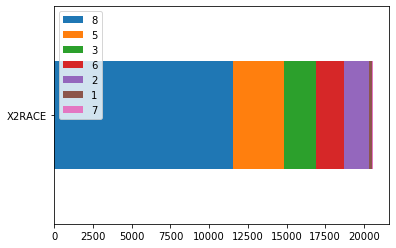

In [596]:
plt.figure(figsize = (20,20))
ax = demo_df.plot.barh(stacked=True)

## Racial Breakdown of STEM vs Non STEM

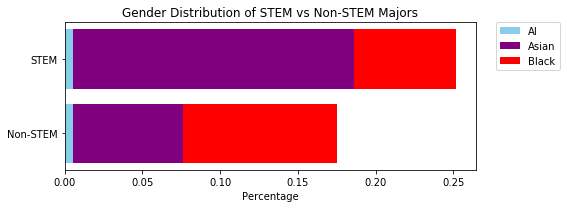

In [686]:
#create dataframe of groupby object
target_race = pd.DataFrame(modeling_df.groupby(by = ['target'])['X2RACE'].value_counts(normalize = True))
#change name of column to value to not confused with target variable
target_race.rename(columns = {'X2RACE':'value'}, inplace = True)
#change multindex to individual columns
target_race.reset_index(inplace=True, level = ('target', 'X2RACE'))

ai = target_race[target_race['X2RACE'] == 1]['value'].values
asian = target_race[target_race['X2RACE'] == 2]['value'].values
black = target_race[target_race['X2RACE'] == 3]['value'].values
hispanic = target_race[target_race['X2RACE'] == 5]['value'].values
multiple = target_race[target_race['X2RACE'] == 6]['value'].values
nh = target_race[target_race['X2RACE'] == 7]['value'].values
white = target_race[target_race['X2RACE'] == 8]['value'].values


label = ['Non-STEM', 'STEM']
fig = plt.figure(figsize = (8, 3))
ax = fig.add_subplot(111)
ax.barh(label, ai, align='center', color='skyblue',label='AI')
ax.barh(label, asian, align='center', left=ai, color='purple',label='Asian')
ax.barh(label, black, align='center', left=asian, color='red',label='Black')
#ax.barh(label, hispanic, align='center', left=black, color='orange',label='Hispanic')
#ax.barh(label, multiple, align='center', left=hispanic, color='yellow',label='Multiple')
#ax.barh(label, nh, align='center', left=multiple, color='green',label='NH')
#ax.barh(label, white, align='center', left=multiple, color='blue',label='White')

ax.set_yticks(label)
ax.set_xlabel('Percentage')
ax.set_title('Racial Distribution of STEM vs Non-STEM Majors')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

In [742]:
df['engineering'].sum()

388

In [759]:
enrollment = [df['chem'].sum(), df['bio'].sum(), df['physics'].sum(), df['enviro'].sum(), df['compsci'].sum(), df['engineering'].sum(),df['misc_class'].sum()]
classes = ['Chemistry', 'Biology', 'Physics', 'Environmental Science', 'Computer Science', 'Engineering','Miscellaneous Class']


<BarContainer object of 7 artists>

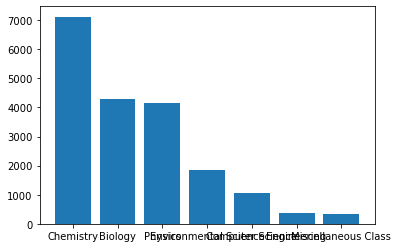

In [760]:
plt.bar(classes, enrollment)

In [827]:
race_df = pd.DataFrame(data = modeling_df.X2RACE.value_counts(normalize = True))
race_df.rename(columns = {'X2RACE': 'Overall'}, inplace= True)
stem_race_df = pd.DataFrame(data = modeling_df[modeling_df['target'] ==1].X2RACE.value_counts(normalize = True))
stem_race_df.rename(columns = {'X2RACE': 'STEM'}, inplace= True)
race_dist = pd.concat([race_df, stem_race_df], axis = 1)

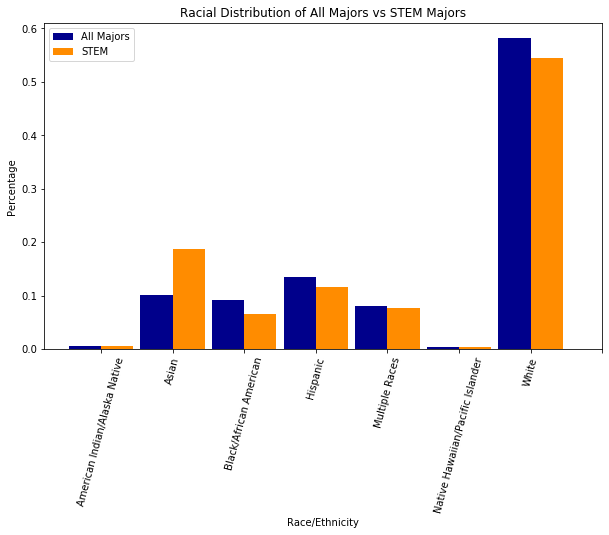

In [828]:
x = np.arange(len(race_dist))
width = 0.45

fig, ax = plt.subplots(figsize= (10, 6))
ax.bar(x - width/2, race_dist['Overall'], width, 
                label='All Majors', color = 'darkblue')
ax.bar(x + width/2, race_dist['STEM'], width, 
                label='STEM', color = 'darkorange')

ax.set_ylabel('Percentage')
ax.set_xlabel('Race/Ethnicity')
ax.set_title('Racial Distribution of All Majors vs STEM Majors')
plt.xticks(ticks = range(0,8), rotation = 75, labels = ['American Indian/Alaska Native', 'Asian', 'Black/African American', 
                                                        'Hispanic', 'Multiple Races', 'Native Hawaiian/Pacific Islander', 'White'])

ax.legend();

In [67]:
racegender_df = pd.DataFrame(data = modeling_df.groupby(by = ['X2RACE'])['X2SEX'].value_counts(normalize = False).unstack())
#race_df.rename(columns = {'X2RACE': 'Overall'}, inplace= True)
stem_racegender_df = pd.DataFrame(data = modeling_df[modeling_df['target'] ==1].groupby(by=['X2RACE'])['X2SEX'].value_counts(normalize = False).unstack())
#stem_race_df.rename(columns = {'X2RACE': 'STEM'}, inplace= True)
racegender_dist = pd.concat([racegender_df, stem_racegender_df], axis = 1)
racegender_dist.columns = ['male_all', 'female_all', 'male_stem', 'female_stem']


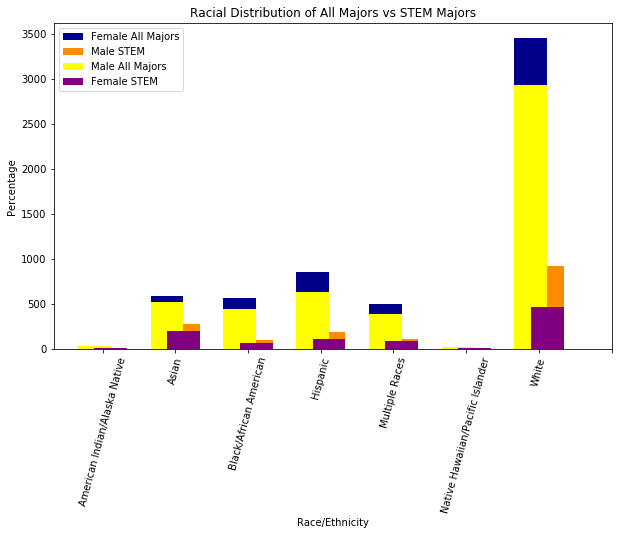

In [68]:
x = np.arange(len(racegender_dist))
width = 0.45

fig, ax = plt.subplots(figsize= (10, 6))
ax.bar(x - width/4, racegender_dist['female_all'], width, 
                label='Female All Majors', color = 'darkblue')
ax.bar(x + width/4, racegender_dist['male_stem'], width, 
                label='Male STEM', color = 'darkorange')

ax.bar(x - width/4, racegender_dist['male_all'], width, 
                label='Male All Majors', color = 'yellow')
ax.bar(x + width/4, racegender_dist['female_stem'], width, 
                label='Female STEM', color = 'purple')

ax.set_ylabel('Percentage')
ax.set_xlabel('Race/Ethnicity')
ax.set_title('Racial Distribution of All Majors vs STEM Majors')
plt.xticks(ticks = range(0,8), rotation = 75, labels = ['American Indian/Alaska Native', 'Asian', 'Black/African American', 
                                                        'Hispanic', 'Multiple Races', 'Native Hawaiian/Pacific Islander', 'White'])

ax.legend();

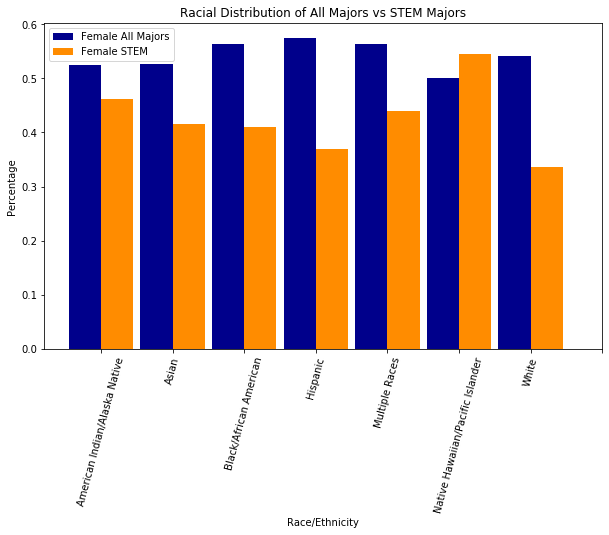

In [65]:
x = np.arange(len(racegender_dist))
width = 0.45

fig, ax = plt.subplots(figsize= (10, 6))
ax.bar(x - width/2, racegender_dist['female_all'], width, 
                label='Female All Majors', color = 'darkblue')
ax.bar(x + width/2, racegender_dist['female_stem'], width, 
                label='Female STEM', color = 'darkorange')

ax.set_ylabel('Percentage')
ax.set_xlabel('Race/Ethnicity')
ax.set_title('Racial Distribution of All Majors vs STEM Majors')
plt.xticks(ticks = range(0,8), rotation = 75, labels = ['American Indian/Alaska Native', 'Asian', 'Black/African American', 
                                                        'Hispanic', 'Multiple Races', 'Native Hawaiian/Pacific Islander', 'White'])

ax.legend();

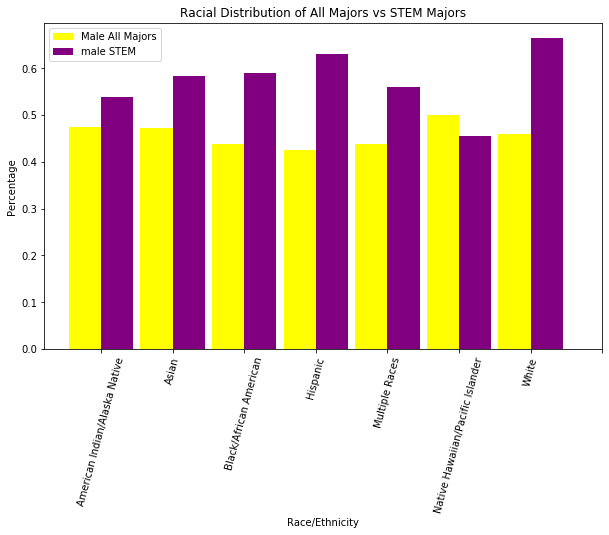

In [66]:
x = np.arange(len(racegender_dist))
width = 0.45

fig, ax = plt.subplots(figsize= (10, 6))

ax.bar(x - width/2, racegender_dist['male_all'], width, 
                label='Male All Majors', color = 'yellow')
ax.bar(x + width/2, racegender_dist['male_stem'], width, 
                label='male STEM', color = 'purple')

ax.set_ylabel('Percentage')
ax.set_xlabel('Race/Ethnicity')
ax.set_title('Racial Distribution of All Majors vs STEM Majors')
plt.xticks(ticks = range(0,8), rotation = 75, labels = ['American Indian/Alaska Native', 'Asian', 'Black/African American', 
                                                        'Hispanic', 'Multiple Races', 'Native Hawaiian/Pacific Islander', 'White'])

ax.legend();

In [829]:
expects_career = df[df['X2STU30OCC_STEM1'] == 1]

In [831]:
expects_career.X2SEX.value_counts(normalize = True
                           )

2    0.604502
1    0.395498
Name: X2SEX, dtype: float64

In [832]:
target_df.X2SEX.value_counts(normalize = True)

1    0.630673
2    0.369327
Name: X2SEX, dtype: float64

In [834]:
modeling_df.X2SEX.value_counts(normalize = True)

2    0.547567
1    0.452433
Name: X2SEX, dtype: float64

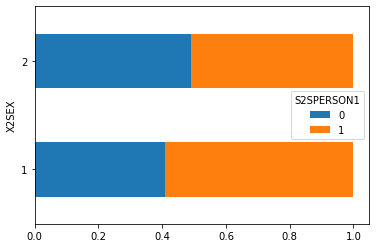

In [844]:
modeling_df.groupby(['X2SEX'])['S2SPERSON1'].value_counts(normalize = True).unstack().plot(kind = 'barh', stacked = True)

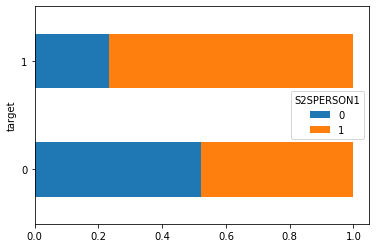

In [845]:
modeling_df.groupby(['target'])['S2SPERSON1'].value_counts(normalize = True).unstack().plot(kind = 'barh', stacked = True)